In [14]:
import numpy as np
import pandas as pd
import dataframe_image as dfi

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.image as mpimg

import statsmodels.api as sm
import seaborn as sns

import folium
import json

import pickle

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
# 데이터프레임을 그림 파일로 저장
save_option = 1 # 3 : dfi / 2 : df2img / 3 : do nothing
K_option = 6 # 군집수 (5, 6, 7)
suffix = "_"
import df2img
def save(df:pd.DataFrame, path:str, extension:str):
    path = path + suffix + "K=" + str(K_option) + "." + extension
    if extension == 'png':
        if save_option == 1:
            dfi.export(df, path)
        if save_option == 2:
            df2img.save_dataframe(fig=df2img.plot_dataframe(df), filename=path)
        if save_option == 3:
            pass
    if extension == 'csv':
        df.to_csv(path, encoding="utf-8-sig")

In [3]:
# 한글 폰트 사용을 위해서 세팅
from matplotlib import font_manager, rc
font_path = "C:\Windows\Fonts\malgun.ttf"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

## 데이터 불러오기 및 병합

In [4]:
collected_data = pd.read_csv('../../data/data_c_final/2c201_1230_collected_data.csv')
collected_data.set_index("지역", inplace=True)
collected_data.head()

,쏘카존 수,인구,2030인구,아파트 수,행복주택 수,지하철역 수,환승역 수,정류장 수,대학교 수,대학생 수,녹지,주거,공업,상업,위도,경도,면적
지역,,,,,,,,,,,,,,,,,
수원시 장안구,18,271012,82294.55980,200,0,1,0,409,0,34441,0.272727,0.727273,0.000000,0.000000,37.303971,127.001743,33.34
수원시 권선구,16,367004,111443.15610,159,1,4,0,537,0,11033,0.625000,0.312500,0.062500,0.000000,37.257687,126.963532,47.17
수원시 팔달구,20,192225,58370.37385,65,1,4,2,185,0,0,0.136364,0.409091,0.000000,0.454545,37.282570,127.011718,12.86
수원시 영통구,34,360127,109354.91020,129,3,6,0,380,0,22911,0.142857,0.571429,0.285714,0.000000,37.259600,127.042341,27.72
용인시 처인구,29,259872,67270.69540,112,1,9,0,1234,0,13084,0.823529,0.058824,0.000000,0.117647,37.234346,127.192965,467.65


In [12]:
# collected_data.sort_values(by='지역',inplace=True)
# collected_data['dumb'] = np.arange(len(collected_data))
# collected_data

In [13]:
hackathon_data_original = pd.read_csv("../../../socar_data/20211022_수요예측_hackathon_data.csv", encoding='cp949')
hackathon_data_original.head()

,region1,region2,reservation_return_at,reservation_start_at,age_group,gender,car_model
0,울산광역시,남구,2019-09-29 21:25:40+00:00,2019-09-29 19:20:00+00:00,1,male,경형
1,울산광역시,남구,2019-07-13 13:11:21+00:00,2019-07-13 11:00:00+00:00,1,male,준중형
2,울산광역시,남구,2019-09-16 23:43:08+00:00,2019-09-16 19:10:00+00:00,1,male,준중형
3,울산광역시,남구,2019-08-09 06:17:41+00:00,2019-08-09 00:20:00+00:00,1,male,준중형
4,울산광역시,남구,2019-07-24 12:36:29+00:00,2019-07-24 09:00:00+00:00,2,male,경형


In [15]:
hackathon_data = pd.DataFrame(hackathon_data_original['region2'].value_counts())
hackathon_data.reset_index(inplace=True)
with open('../code_a_collect_data/results/1b203_0208_remove_u3000.pkl', 'rb') as f:
    remove_u3000 = pickle.load(f)
hackathon_data['index'].replace(remove_u3000, inplace=True)
hackathon_data.columns = ['지역', '이용 수']
hackathon_data.set_index('지역', inplace=True)
hackathon_data.head()

,이용 수
지역,
성남시 분당구,46782
화성시,35249
고양시 일산동구,31906
남양주시,26546
고양시 덕양구,26253


In [16]:
intersected_rows = set.intersection(set(collected_data.index), set(hackathon_data.index))
intersected_rows = list(intersected_rows)
print(len(intersected_rows),'개 지역 \n',intersected_rows)

16 개 지역 
 ['안양시 동안구', '안양시 만안구', '성남시 수정구', '하남시', '김포시', '광명시', '화성시', '고양시 일산동구', '남양주시', '성남시 분당구', '의정부시', '고양시 덕양구', '양평군', '성남시 중원구', '구리시', '고양시 일산서구']


In [18]:
collected_data_intersected = collected_data[collected_data.index.isin(intersected_rows)]
collected_data_intersected.sort_index(ascending=True, inplace=True)
hackathon_data_intersected = hackathon_data[hackathon_data.index.isin(intersected_rows)]
hackathon_data_intersected.sort_index(ascending=True, inplace=True)
intersected = pd.concat([collected_data_intersected, hackathon_data_intersected],axis=1)
intersected['쏘카존 수 대비 이용 수'] = intersected['이용 수']/intersected['쏘카존 수']
intersected.head()

,쏘카존 수,인구,2030인구,아파트 수,행복주택 수,지하철역 수,환승역 수,정류장 수,대학교 수,대학생 수,녹지,주거,공업,상업,위도,경도,면적,이용 수,쏘카존 수 대비 이용 수
지역,,,,,,,,,,,,,,,,,,,
고양시 덕양구,48,487874,131281.05900,274,8,9,2,1205,0,4210,0.656250,0.343750,0.0,0.000000,37.637431,126.823745,165.0,26253,546.937500
고양시 일산동구,51,296590,79808.82212,133,0,6,0,454,0,13923,0.461538,0.461538,0.0,0.076923,37.658622,126.771006,59.0,31906,625.607843
고양시 일산서구,29,290738,78234.11890,140,0,4,0,635,0,0,0.500000,0.375000,0.0,0.125000,37.677991,126.741105,42.0,16052,553.517241
광명시,28,288182,76757.00000,89,0,3,0,445,0,0,0.222222,0.666667,0.0,0.111111,37.478618,126.856271,38.5,22645,808.750000
구리시,19,188876,51033.00000,111,1,2,0,313,0,0,0.500000,0.500000,0.0,0.000000,37.594266,127.121253,33.3,13011,684.789474


# 군집화

In [19]:
# X : clustering에 사용할 data, 상관관계 분석을 통해 봤을 때, 딱히 제거할 만한 feature가 보이지 않는다.
X = collected_data.copy()
X.drop(columns = ['위도', '경도', '면적', '대학교 수', '대학생 수', '행복주택 수']) # 행복주택도 빼야 할 것 같은데..
# y : clustering의 결과를 기록할 dataframe
y = pd.DataFrame(index = collected_data.index)
# X.drop(columns = ['위도', '경도', '대학교 수'], inplace=True)
X.shape, y.shape

((42, 17), (42, 0))

## elbow method

In [20]:
distortions = []
for k in range(1,20):
    kmean = KMeans(n_clusters=k, random_state=0, n_init=50, max_iter=500)
    # centroid들의 intialization이 50종류이다.
    # 각 종류의 initialization에 대하여 iteration을 최대 500번 진행한다. (500번보다 적은 iteration동안 centroid가 더이상 움직이지 않으면, 거기서 멈춘다.)
    # 사실 두 값을 적게 잡아도 큰 차이가 나지는 않지만, 학습과정에 큰 시간이 들지 않으므로 넉넉하게 50, 500으로 잡았다.
    kmean.fit(X)
    distortions.append(kmean.inertia_)

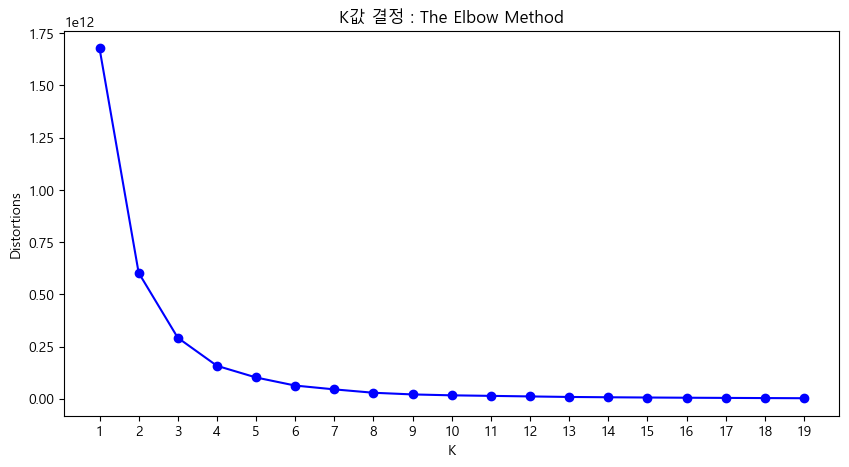

In [21]:
plt.figure(figsize=(10,5))
plt.plot(range(1,20), distortions, 'bo-')
plt.xlabel('K')
plt.ylabel('Distortions')
plt.xticks(range(1,20))
plt.title('K값 결정 : The Elbow Method')
plt.savefig('results/1b211_0112_elbow.png')
plt.show()

**K means clustering과 elbow method**

16차원의 유클리드 공간에 42개의 점이 찍혀져 있다.
(16 : feature의 개수, 42 : 지역의 개수)
이 42개의 점을 K개의 군집 $S_1$, $S_2$, $\cdots$, $S_{K}$으로 묶는다.
묶는 방식은, 군집들이 각 군집의 무게중심(centroid, $\mu_k$)에 잘 뭉쳐지는 방식으로 묶는다.
다시 말해,
$$\sum_{k=1}^K\sum_{\mathbf x\in S_k}||\mathbf x-\mu_k||^2$$
이 최소화되도록 하는 군집 $S$를 찾는다.
최소화해야 하는 위 식의 값을 distortion이라고도 부른다.
최소화시킨 distortion의 값을 $D(K)$라고 쓰면,
$$D(K)=\min_{S}\sum_{k=1}^K\sum_{\mathbf x\in S_k}||\mathbf x-\mu_k||^2$$
이다. (단, $S=\{S_1, S_2, \cdots, S_{K}\}$)
K의 값이 증가할 수록 $D(K)$의 값은 감소하는 것이 당연하다.
한편, $D(K)$의 값이 작아지는 $K$값을 선정하는 것이 바람직하지만, 군집의 수(=K)가 너무 많아지면 군집화하는 의미가 별로 없다.
따라서, $D(K)$의 값이 최솟값에 도달하는 $K$의 값, 다시 말해, $D(K)$의 그래프가 평평해지는 순간의 $K$를 선정하는 것이 가장 좋다.
위 그래프에서 $K$값은 4,5,6,7,8 중의 하나의 값으로 선정하는 것이 적당해보인다.

## K값 결정

In [22]:
pearsonK = pd.DataFrame(index = ['행복주택 수'])
for K in range(4,9): # K = 4, 5, 6, 7, 8
    kmeans = KMeans(n_clusters=K, random_state=0).fit(X)
    y['군집'] = kmeans.labels_
    collected_data_clustered = pd.concat([collected_data, y], axis = 1)
    intersected_ = intersected.copy()
    intersected_['군집'] = intersected_.index.map(dict(zip(collected_data_clustered.index, collected_data_clustered['군집'])))
    pearsonK['K='+str(K)] = (intersected_.corr()['군집']['행복주택 수'])
pearsonK

,K=4,K=5,K=6,K=7,K=8
행복주택 수,0.291779,-0.008573,-0.264313,-0.113239,0.554088


In [23]:
K = K_option
cluster_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
cluster_names = cluster_names[:K]
cluster_names

['A', 'B', 'C', 'D', 'E', 'F']

In [24]:
int_to_name = dict(zip(range(K),cluster_names))
name_to_int = dict(zip(cluster_names,range(K)))
print(int_to_name[0])
print(name_to_int['A'])

A
0


In [25]:
kmeans = KMeans(n_clusters=K, random_state=0).fit(X)
y['군집'] = kmeans.labels_
for k in range(K):
    print('cluster', cluster_names[k], ' : ', sorted(y.index[y['군집']==k].tolist()))

cluster A  :  ['고양시 덕양구', '김포시', '성남시 분당구', '시흥시', '용인시 기흥구', '의정부시', '파주시']
cluster B  :  ['구리시', '군포시', '성남시 수정구', '성남시 중원구', '수원시 장안구', '수원시 팔달구', '안성시', '안양시 만안구', '양주시', '오산시', '용인시 처인구', '의왕시', '이천시']
cluster C  :  ['남양주시', '부천시', '화성시']
cluster D  :  ['가평군', '과천시', '동두천시', '양평군', '여주시', '연천군', '포천시']
cluster E  :  ['고양시 일산동구', '고양시 일산서구', '광명시', '광주시', '수원시 권선구', '수원시 영통구', '안산시 단원구', '안산시 상록구', '안양시 동안구', '용인시 수지구', '하남시']
cluster F  :  ['평택시']


In [26]:
textfile1 = open('results/1b212_0201_clustering_result'+suffix+"K="+str(K_option) +'.txt', 'w')
textfile2 = open('../../data/data_c_final/2c203_0126_clustering_result'+suffix+"K="+str(K_option) +'.txt', 'w')
for k in range(K):
    a = 'cluster '+str(cluster_names[k])+' : ' + str(y.index[y['군집']==k].to_list())
    textfile1.write(a)
    textfile2.write(a)
    textfile1.write('\n')
    textfile2.write('\n')
textfile1.close()
textfile2.close()

In [27]:
clustering_result = pd.DataFrame({'군집': cluster_names, '소속도시': [y.index[y['군집'] == k].tolist() for k in range(K)]}).set_index('군집')
save(clustering_result, "results/1b213_0126_clustering_result", "csv")
save(clustering_result, "../../data/data_c_final/2c204_0126_clustering_result", "csv")
clustering_result

,소속도시
군집,
A,"[용인시 기흥구, 성남시 분당구, 시흥시, 김포시, 고양시 덕양구, 파주시, 의정부시]"
B,"[수원시 장안구, 수원시 팔달구, 용인시 처인구, 성남시 수정구, 성남시 중원구, ..."
C,"[부천시, 화성시, 남양주시]"
D,"[양평군, 여주시, 과천시, 포천시, 동두천시, 가평군, 연천군]"
E,"[수원시 권선구, 수원시 영통구, 용인시 수지구, 안산시 상록구, 안산시 단원구, ..."
F,[평택시]


## 군집화 결과 분석

In [28]:
# 군집 결과를 추가한 데이터셋
collected_data_clustered = pd.concat([collected_data, y], axis = 1)
collected_data_clustered['군집'] = collected_data_clustered['군집'].apply(lambda x:int_to_name[x])
collected_data_clustered.head()

,쏘카존 수,인구,2030인구,아파트 수,행복주택 수,지하철역 수,환승역 수,정류장 수,대학교 수,대학생 수,녹지,주거,공업,상업,위도,경도,면적,군집
지역,,,,,,,,,,,,,,,,,,
수원시 장안구,18,271012,82294.55980,200,0,1,0,409,0,34441,0.272727,0.727273,0.000000,0.000000,37.303971,127.001743,33.34,B
수원시 권선구,16,367004,111443.15610,159,1,4,0,537,0,11033,0.625000,0.312500,0.062500,0.000000,37.257687,126.963532,47.17,E
수원시 팔달구,20,192225,58370.37385,65,1,4,2,185,0,0,0.136364,0.409091,0.000000,0.454545,37.282570,127.011718,12.86,B
수원시 영통구,34,360127,109354.91020,129,3,6,0,380,0,22911,0.142857,0.571429,0.285714,0.000000,37.259600,127.042341,27.72,E
용인시 처인구,29,259872,67270.69540,112,1,9,0,1234,0,13084,0.823529,0.058824,0.000000,0.117647,37.234346,127.192965,467.65,B


In [29]:
save(collected_data_clustered, "results/1b214_0112_collected_data_clustered", 'csv')
save(collected_data_clustered, "results/1b215_0112_collected_data_clustered", 'png')
save(collected_data_clustered, "../../data/data_c_final/2c205_0112_collected_data_clustered", 'csv')
save(collected_data_clustered, "../../data/data_c_final/2c206_0112_collected_data_clustered", 'png')

In [30]:
# 군집과 기존 feature들 간의 상관계수
intersected_ = intersected.copy()
intersected_['군집'] = intersected_.index.map(dict(zip(collected_data_clustered.index, collected_data_clustered['군집'])))
intersected_['군집'] = intersected_['군집'].apply(lambda x:name_to_int[x])
intersected_.corr()[['군집']]

,군집
쏘카존 수,-0.256995
인구,-0.225501
2030인구,-0.232860
아파트 수,-0.349845
행복주택 수,-0.264313
지하철역 수,-0.478563
환승역 수,-0.447776
정류장 수,-0.137566
대학교 수,-0.048351
대학생 수,-0.062028


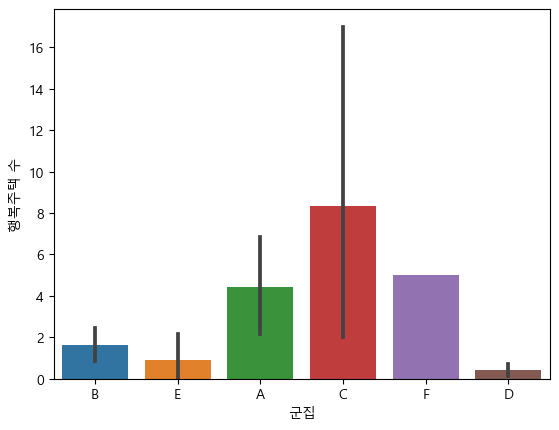

In [31]:
plt.rcParams['font.family'] = 'Malgun Gothic'
sns.barplot(x="군집", y="행복주택 수", data=collected_data_clustered)#, ci=None)
# plt.savefig("results/1b_204_0112_cluster_result_happyhouse"+"K="+str(K)+".png")
plt.show()

In [32]:
# 다른 feature들과 군집화 사이의 관계
collected_data_clustered.groupby('군집').mean()

,쏘카존 수,인구,2030인구,아파트 수,행복주택 수,지하철역 수,환승역 수,정류장 수,대학교 수,대학생 수,녹지,주거,공업,상업,위도,경도,면적
군집,,,,,,,,,,,,,,,,,
A,43.714286,480541.571429,129846.917186,259.714286,4.428571,11.857143,1.285714,1228.000000,2.285714,4173.000000,0.617036,0.336692,0.031201,0.015071,37.542071,126.905596,212.391429
B,15.769231,222699.076923,61630.326942,117.000000,1.615385,3.692308,0.461538,644.615385,2.538462,9499.000000,0.542483,0.347954,0.038967,0.070596,37.354211,127.093336,161.034615
C,56.666667,812195.666667,220557.666667,431.000000,8.333333,11.333333,1.333333,1928.666667,14.333333,10990.000000,0.441551,0.480140,0.069300,0.009009,37.446381,126.930976,401.813333
D,5.428571,93776.857143,19921.428571,45.000000,0.428571,3.571429,0.000000,763.571429,4.000000,3194.142857,0.859127,0.117063,0.011905,0.011905,37.706587,127.271268,566.357143
E,27.727273,332181.727273,93037.211768,138.454545,0.909091,5.272727,0.454545,545.727273,1.000000,7531.818182,0.464258,0.456148,0.051136,0.028458,37.421411,126.956040,86.503636
F,53.000000,577335.000000,316322.000000,367.000000,5.000000,5.000000,0.000000,1839.000000,9.000000,9989.000000,0.594595,0.270270,0.081081,0.054054,36.989606,127.105102,458.300000


In [33]:
# 다른 feature들과 군집화 사이의 관계 : 주요 feature들
collected_data_clustered_ = collected_data_clustered[['쏘카존 수', '인구', '2030인구', '아파트 수', '행복주택 수', '지하철역 수', '환승역 수', '정류장 수',
                                                    '대학교 수', '대학생 수', '군집']].groupby('군집').mean()
collected_data_clustered_

,쏘카존 수,인구,2030인구,아파트 수,행복주택 수,지하철역 수,환승역 수,정류장 수,대학교 수,대학생 수
군집,,,,,,,,,,
A,43.714286,480541.571429,129846.917186,259.714286,4.428571,11.857143,1.285714,1228.000000,2.285714,4173.000000
B,15.769231,222699.076923,61630.326942,117.000000,1.615385,3.692308,0.461538,644.615385,2.538462,9499.000000
C,56.666667,812195.666667,220557.666667,431.000000,8.333333,11.333333,1.333333,1928.666667,14.333333,10990.000000
D,5.428571,93776.857143,19921.428571,45.000000,0.428571,3.571429,0.000000,763.571429,4.000000,3194.142857
E,27.727273,332181.727273,93037.211768,138.454545,0.909091,5.272727,0.454545,545.727273,1.000000,7531.818182
F,53.000000,577335.000000,316322.000000,367.000000,5.000000,5.000000,0.000000,1839.000000,9.000000,9989.000000


In [34]:
scaler = MinMaxScaler()
collected_data_clustered_scaled = scaler.fit_transform(collected_data_clustered.drop('군집', axis=1))
collected_data_clustered_scaled = pd.DataFrame(collected_data_clustered_scaled, columns=collected_data_clustered.columns[:-1], index=collected_data_clustered.index)
collected_data_clustered_scaled['군집'] = collected_data_clustered['군집']
collected_data_clustered_scaled.head()

,쏘카존 수,인구,2030인구,아파트 수,행복주택 수,지하철역 수,환승역 수,정류장 수,대학교 수,대학생 수,녹지,주거,공업,상업,위도,경도,면적,군집
지역,,,,,,,,,,,,,,,,,,
수원시 장안구,0.272727,0.264331,0.237966,0.366337,0.000000,0.047619,0.000000,0.126241,0.0,1.000000,0.157895,0.969697,0.00000,0.000000,0.283945,0.319660,0.023678,B
수원시 권선구,0.236364,0.375201,0.332879,0.285149,0.058824,0.190476,0.000000,0.171631,0.0,0.320345,0.565789,0.416667,0.21875,0.000000,0.242140,0.278195,0.039667,E
수원시 팔달구,0.309091,0.173332,0.160065,0.099010,0.058824,0.190476,0.666667,0.046809,0.0,0.000000,0.000000,0.545455,0.00000,1.000000,0.264615,0.330484,0.000000,B
수원시 영통구,0.563636,0.367258,0.326079,0.225743,0.176471,0.285714,0.000000,0.115957,0.0,0.665225,0.007519,0.761905,1.00000,0.000000,0.243868,0.363714,0.017180,E
용인시 처인구,0.472727,0.251464,0.189046,0.192079,0.058824,0.428571,0.000000,0.418794,0.0,0.379896,0.795666,0.078431,0.00000,0.258824,0.221058,0.527162,0.525805,B


In [35]:
# 다른 feature들과 군집화 사이의 관계
collected_data_clustered_scaled.groupby('군집').mean()

,쏘카존 수,인구,2030인구,아파트 수,행복주택 수,지하철역 수,환승역 수,정류장 수,대학교 수,대학생 수,녹지,주거,공업,상업,위도,경도,면적
군집,,,,,,,,,,,,,,,,,
A,0.740260,0.506336,0.392805,0.484583,0.260504,0.564626,0.428571,0.416667,0.084656,0.121164,0.556568,0.448923,0.109203,0.033155,0.499005,0.215326,0.230688
B,0.232168,0.208530,0.170680,0.201980,0.095023,0.175824,0.153846,0.209793,0.094017,0.275805,0.470244,0.463939,0.136383,0.155311,0.329324,0.419050,0.171312
C,0.975758,0.889395,0.688175,0.823762,0.490196,0.539683,0.444444,0.665130,0.530864,0.319096,0.353375,0.640187,0.242550,0.019820,0.412575,0.242868,0.449688
D,0.044156,0.059625,0.034868,0.059406,0.025210,0.170068,0.000000,0.251976,0.148148,0.092742,0.836884,0.156085,0.041667,0.026190,0.647602,0.612132,0.639925
E,0.449587,0.334982,0.272946,0.244464,0.053476,0.251082,0.151515,0.174726,0.037037,0.218688,0.379667,0.608197,0.178977,0.062607,0.390021,0.270065,0.085143
F,0.909091,0.618132,1.000000,0.697030,0.294118,0.238095,0.000000,0.633333,0.333333,0.290032,0.530583,0.360360,0.283784,0.118919,0.000000,0.431818,0.514995


총 17개 feature
- 주거 : 인구, 2030인구, 아파트 수, 행복주택 수, 주거 : 5(5)
- 교통 : 지하철역 수, 환승역 수, 정류장 수 : 3(3)
- 지리 : 위도, 경도, 면적 : 0(3)
- 대학 : 대학교 수, 대학생 수 : 0(2)
- 기타 : 쏘카존 수, 녹지, 공업, 상업 4(4)

In [36]:
# 다른 feature들과 군집화 사이의 관계 : 주요 feature들
collected_data_clustered_scaled_ = collected_data_clustered_scaled[['쏘카존 수', '인구', '2030인구', '아파트 수', '지하철역 수', '환승역 수', '정류장 수', '녹지', '공업', '상업', '군집']].groupby('군집').mean()
collected_data_clustered_scaled_

,쏘카존 수,인구,2030인구,아파트 수,지하철역 수,환승역 수,정류장 수,녹지,공업,상업
군집,,,,,,,,,,
A,0.740260,0.506336,0.392805,0.484583,0.564626,0.428571,0.416667,0.556568,0.109203,0.033155
B,0.232168,0.208530,0.170680,0.201980,0.175824,0.153846,0.209793,0.470244,0.136383,0.155311
C,0.975758,0.889395,0.688175,0.823762,0.539683,0.444444,0.665130,0.353375,0.242550,0.019820
D,0.044156,0.059625,0.034868,0.059406,0.170068,0.000000,0.251976,0.836884,0.041667,0.026190
E,0.449587,0.334982,0.272946,0.244464,0.251082,0.151515,0.174726,0.379667,0.178977,0.062607
F,0.909091,0.618132,1.000000,0.697030,0.238095,0.000000,0.633333,0.530583,0.283784,0.118919


In [37]:
displayed_features = [pd.DataFrame(collected_data_clustered_scaled_.iloc[i]).sort_values(by=str(cluster_names[i]),
                        ascending=False).reset_index().rename(columns={'index':'index_'+str(cluster_names[i]),
                        str(cluster_names[i]):'corr_'+str(cluster_names[i])}) for i in range(K)]
pd.concat(displayed_features, axis=1)[:3]

,index_A,corr_A,index_B,corr_B,index_C,corr_C,index_D,corr_D,index_E,corr_E,index_F,corr_F
0,쏘카존 수,0.740260,녹지,0.470244,쏘카존 수,0.975758,녹지,0.836884,쏘카존 수,0.449587,2030인구,1.000000
1,지하철역 수,0.564626,쏘카존 수,0.232168,인구,0.889395,정류장 수,0.251976,녹지,0.379667,쏘카존 수,0.909091
2,녹지,0.556568,정류장 수,0.209793,아파트 수,0.823762,지하철역 수,0.170068,인구,0.334982,아파트 수,0.697030


In [38]:
for k in range(K):
    print('cluster', cluster_names[k], ' : ', sorted(y.index[y['군집']==k].tolist()))

cluster A  :  ['고양시 덕양구', '김포시', '성남시 분당구', '시흥시', '용인시 기흥구', '의정부시', '파주시']
cluster B  :  ['구리시', '군포시', '성남시 수정구', '성남시 중원구', '수원시 장안구', '수원시 팔달구', '안성시', '안양시 만안구', '양주시', '오산시', '용인시 처인구', '의왕시', '이천시']
cluster C  :  ['남양주시', '부천시', '화성시']
cluster D  :  ['가평군', '과천시', '동두천시', '양평군', '여주시', '연천군', '포천시']
cluster E  :  ['고양시 일산동구', '고양시 일산서구', '광명시', '광주시', '수원시 권선구', '수원시 영통구', '안산시 단원구', '안산시 상록구', '안양시 동안구', '용인시 수지구', '하남시']
cluster F  :  ['평택시']


In [39]:
save(collected_data_clustered.groupby('군집').mean(), "results/1b216_0112_features_by_clusters",'png')
save(collected_data_clustered_.groupby('군집').mean(), "results/1b217_0112_features_by_clusters_",'png')
save(collected_data_clustered_scaled.groupby('군집').mean(), "results/1b218_0112_features_by_clusters",'png')
save(collected_data_clustered_scaled_.groupby('군집').mean(), "results/1b219_0112_features_by_clusters_",'png')

# 군집에 대한 시각화

## PCA를 통한 시각화

In [40]:
colors_ = {0:'red', 1:'yellow', 2:'green', 3:'blue', 4:'purple', 5:'black'}

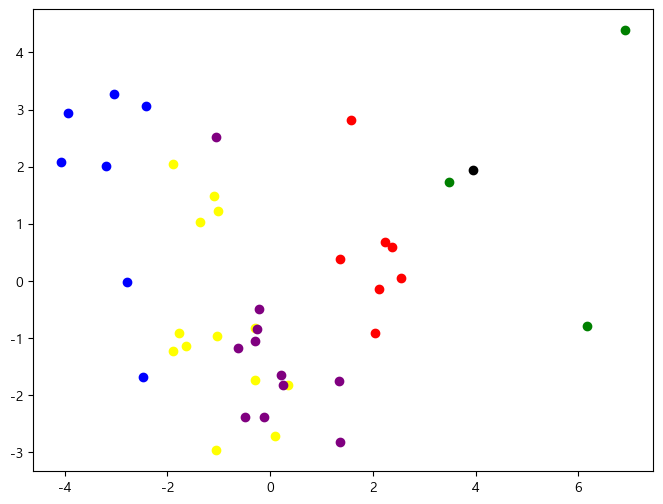

In [41]:
# X에 대하여 standardization 및 PCA를 적용한다. PCA에 간략한 설명은 다음과 같다.
# X는 42개의 14차원의 벡터이다. 이 42개의 벡터들은 서로 직교하지 않은 상태이다.
# 이것을 새로운 42개의 14차원 벡터들로 변환하여 Xt를 만들되, 각각의 벡터들이 서로 직교하도록,
# 그리고 각각의 벡터들이 중요한 의미를 가지도록 변환하는 것이다.
# (조금 더 정확하게는, X와 X transpose의 곱인 square symmetric matrix N에 대하여
# Xt의 42개의 벡터들은 N의 eigenvector가 되고, 그에 대응되는 eigenvalue들은 절댓값이 큰 순으로 정렬되어 있다.)
# Xt의 첫 벡터 PC1(the first principal component)는 X를 projection했을 때, 가장 많은 정보가 보존되는 벡터이다.
# Xt의 두번째 벡터 PC2는 PC1과 직교하는 벡터이면서 X를 projection했을 때, 가장 많은 정보가 보존되는 벡터이다.
# 즉, PC1과 PC2의 방향은, 원래 데이터 X의 정보를 가장 잘 보존시키는 두 개의 벡터이다.
# 이 두 개의 방향에 대한 두 개의 성분들을 고려하면
# 14차원의 정보를 2차원의 정보로 효율적으로 축소시킨 셈이다(dimensionality reduction).
# 이번 코드에서는 이러한 차원축소를 통해, clustering을 시각화하는 데에 사용했다.
# standardization은 이러한 PCA가 더 잘 작용되도록 해준다. 하지만, 이번 경우에는 standardization을 적용하지 않아도 결과가 잘 나타나기는 한다.

pipe = Pipeline([('scaler', StandardScaler()), ('pca', PCA())])
Xt = pipe.fit_transform(X)
Xt.shape, y['군집'].shape
plt.figure(figsize=(8,6))
plt.rcParams['axes.unicode_minus'] = False
for i in range(6):
    Xt_temp = Xt[np.where(y['군집']==i)]
    plt.scatter(Xt_temp[:,0], Xt_temp[:,1], c=colors_[i])
plt.savefig("results/1b220_0112_2d_visualization" + suffix + "K=" + str(K_option) + ".png")
plt.show()
